# Reservoirs tables - GloFAS5
***

**Author:** Chus Casado Rodríguez<br>
**Date:** 16-01-2025<br>

**Introduction:**<br>

* [x] 100-year return period of inflow
* [x] average inflow
* [ ] environmental flow?
* [x] storage capacity
* [x] catchment area
* [x] reservoir area: it would be necessary if we want to model the reservoir surface area
* [ ] elevation crest: it would be necessary if we want to model the reservoir level
* [ ] dam height: it would be necessary if we want to model the reservoir level

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
from shapely.geometry import Point
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from scipy.stats import linregress
import cartopy.crs as ccrs
import cartopy.feature as cf
from datetime import datetime

import sys
sys.path.append('E:/casadje/GitHub/lisflood-utilities/src/')
from lisfloodutilities.thresholds import compute_thresholds_gumbel

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from lisfloodreservoirs.utils.plots import plot_reservoir_map, compare_attributes

## Configuration

In [2]:
# paths
PATH_GLOFAS4 = Path('Z:/nahaUsers/casadje/GloFASv4')
PATH_GLOFAS5 = Path('Z:/nahaUsers/casadje/GloFASv5')
PATH_GRAND = Path('Z:/nahaUsers/casadje/datasets/reservoirs/GRanD/v1_3')
PATH_GLWD = Path('Z:/nahaUsers/casadje/datasets/lakes/GLWD')
PATH_ICOLD= Path('Z:/nahaUsers/casadje/datasets/reservoirs/ICOLD/2023')
PATH_OUT = PATH_GLOFAS5 / 'reservoirs' / 'tables'

# minimum storage capacity included in GloFAS
MIN_VOLUME = 100 # hm³
MIN_CATCHMENT = 500 # km²
MIN_AREA = None # 50 # km2
MIN_DOR = 0.08 #

In [3]:
PATH_PLOTS = PATH_OUT / 'plots'
PATH_PLOTS.mkdir(parents=True, exist_ok=True)

## Data

### GloFAS5

In [ ]:
# import TXT of relocated reservoirs
# glofas5 = pd.read_csv(PATH_GLOFAS5 / 'reservoirs' / 'tables' / 'reservoirGlofas_20241202.txt', sep='\t')
# glofas5 = pd.read_excel(PATH_GLOFAS5 / 'reservoirs' / 'tables' / 'reservoirs_glofas5.xlsx', sheet_name='20241202')
glofas5 = gpd.read_file(PATH_GLOFAS5 / 'reservoirs' / 'tables' / 'ReservoirGlofas.shp')

In [ ]:
glofas5.head()

In [ ]:
id_cols = ['RES_ID', 'LAK_ID', 'GRAND_ID', 'GLWD_ID']
coord_cols = ['Xlisf', 'Ylisf']
glofas5[id_cols + coord_cols] = glofas5[id_cols + coord_cols].replace(0, np.nan)
glofas5[id_cols] = glofas5[id_cols].astype('Int64')

In [ ]:
# add international code from ICOLD
map_icold = gpd.read_file(PATH_GLOFAS5 / 'reservoirs' / 'reservoirs_glofas5.shp')[['RES_ID', 'GRAND_ID', 'INT_CODE']]
map_icold = map_icold[map_icold.INT_CODE.notnull()]
map_res_icold = {res_id: icold_id for res_id, icold_id in zip(map_icold.RES_ID, map_icold.INT_CODE) if pd.notna(res_id)}
map_grand_icold = {grand_id: icold_id for grand_id, icold_id in zip(map_icold.GRAND_ID, map_icold.INT_CODE) if pd.notna(grand_id)}
glofas5['INT_CODE'] = glofas5.GRAND_ID.map(map_grand_icold)
mask_icold = glofas5[glofas5.INT_CODE.isnull()].index
glofas5.loc[mask_icold, 'INT_CODE'] = glofas5.loc[mask_icold, 'RES_ID'].map(map_res_icold)

In [ ]:
# # keep reservoirs relocated in the LISFLOOD grid
# glofas5 = glofas5[glofas5.Xlisf.notnull() & glofas5.Ylisf.notnull()]

# # convert to GeoPandas
# glofas5 = gpd.GeoDataFrame(glofas5, geometry=[Point(xy) for xy in zip(glofas5.Xlisf, glofas5.Ylisf)], crs='epsg:4326')

# assing ID in descending order of storage capacity
glofas5.sort_values('CAP_MCM', ascending=False, inplace=True)
glofas5.reset_index(drop=True, inplace=True)
glofas5.index.name = 'ID'
glofas5.drop('FID_1', axis=1, errors='ignore', inplace=True)
glofas5 = glofas5[['RES_ID', 'LAK_ID', 'GRAND_ID', 'GLWD_ID', 'INT_CODE', 'geometry']]

print(glofas5.shape)

In [ ]:
# points of interest used to extract values from maps
poi = pd.concat((glofas5.geometry.x, glofas5.geometry.y), axis=1)
poi.columns = ['x', 'y']
poi = poi.to_xarray()

### GloFAS4

#### Reservoirs

In [ ]:
# load shapefile
glofas4 = gpd.read_file(PATH_GLOFAS4 / 'tables' / 'GloFAS_reservoirs.shp')

# assign ID
map_ID = {ResID: ID for ID, ResID in zip(glofas5.index, glofas5.RES_ID) if not pd.isna(ResID)}
glofas4['ID'] = glofas4.ResID.map(map_ID).astype('Int64')

# keep reservoirs in GloFAS4 also in GloFAS5
glofas4.dropna(subset=['ID'], inplace=True)
glofas4.set_index('ID', drop=False, inplace=True)

print(glofas4.shape)

#### Static maps

In [ ]:
# load the upstream area map
uparea = rxr.open_rasterio(PATH_GLOFAS4 / 'static_maps' / 'upArea_repaired.nc').squeeze(dim='band')
uparea = uparea.where(uparea != -999999, np.nan)
uparea /= 1e6 # km2

#### Natural flow

I have run the tool `ncextract` on the EFASv5 long-term run simulation with natural flow, i.e, no reservoirs and no water abstraction. The discharge files resulting from this simulation are in the HPC: `/mnt/DISASTER/FLOODS/nahaUsers/grimast/EFASNatflow/`.

The discharge time series extracted for the reservoir locations are proxies of the reservoir inflow. From these time series we need to estimate the 100-year return period, average inflow and environmental flow.

In [ ]:
# # export CSV needed to run `ncextract`
# points = pd.concat((glofas5.geometry.x, glofas5.geometry.y), axis=1)
# points.columns = ['lon', 'lat']
# points.to_csv(PATH_GLOFAS5 / 'reservoirs' / 'ncextract' / 'reservoirs_glofas5_1545.csv')

In [ ]:
# # daily timeseries of naturalised discharge
# dis_nat = xr.open_dataset(PATH_GLOFAS5 / 'reservoirs' / 'ncextract' / 'nat_dis_GLOFAS4_1545.nc')['dis']
# dis_nat = dis_nat.sel(time=slice('1993-01-02', None))
# dis_nat.close()

In [ ]:
# # 10th percentile of the natural flow
# dis_env_nat = xr.open_dataset(PATH_GLOFAS4 / 'natural_flow' / 'dis_all20_pctl10.nc')['dis'].squeeze('time')

#### Long-term run
Average and 100-year discharge in the long-term run.

In [ ]:
# average discharge
dis_avg_ltr = rxr.open_rasterio(PATH_GLOFAS4 / 'long_run' / 'dis' / 'thresholds' / 'disavg_1979_2023.nc').squeeze(dim='time')
dis_avg_ltr.close()

# 100-year discharge
dis_100_ltr = rxr.open_rasterio(PATH_GLOFAS4 / 'long_run' / 'dis' / 'thresholds' / 'flood_threshold_glofas_v4_rl_100.0.nc').squeeze(dim='band')

### GRanD

In [ ]:
# load raw dataset
grand = gpd.read_file(PATH_GRAND / 'GRanD_dams_v1_3.shp')

# connection between GRanD and ID
map_grand_ID = {grand_id: ID for ID, grand_id in zip(glofas5.index, glofas5.GRAND_ID) if not pd.isna(grand_id)}
grand['ID'] = grand.GRAND_ID.map(map_grand_ID).astype('Int64')
grand = grand[grand.ID.notnull()]
grand.set_index('ID', drop=True, inplace=True)

print(grand.shape)

### GLWD

In [ ]:
# level 1
glwd1 = gpd.read_file(PATH_GLWD / 'level1' / 'glwd_1.shp')#.set_index('GLWD_ID', drop=True)
glwd1 = glwd1[glwd1.GLWD_ID.isin(glofas5.GLWD_ID)]

# level 2
glwd2 = gpd.read_file(PATH_GLWD / 'level2' / 'glwd_2.shp')#.set_index('GLWD_ID', drop=True)
glwd2 = glwd2[glwd2.GLWD_ID.isin(glofas5.GLWD_ID)]

# concatenate
glwd = pd.concat((glwd1, glwd2), axis=0)

if not glwd.shape[0] == glofas5.GLWD_ID.nunique():
    print('The number of lakes in "glwd" does not match the number of lakes in "glofas5" with assigned GLWD_ID')

# connection between GLWD and ID
map_glwd_ID = {glwd_id: ID for ID, glwd_id in glofas5.GLWD_ID.items() if not pd.isna(glwd_id)}
glwd['ID'] = glwd.GLWD_ID.map(map_glwd_ID).astype('Int64')
glwd = glwd[glwd.ID.notnull()]
glwd.set_index('ID', drop=True, inplace=True)

print(glwd.shape)

### ICOLD

In [ ]:
# load ICOLD dataset
icold = gpd.read_file(PATH_ICOLD / 'ICOLD_global.shp')

# connection between ICOLD and ID
map_icold_ID = {icold_id: ID for ID, icold_id in glofas5.INT_CODE.items() if pd.notna(icold_id)}
icold['ID'] = icold.Int_Code.map(map_icold_ID).astype('Int64')
icold = icold[icold.ID.notnull()]
icold.set_index('ID', drop=True, inplace=True)

print(icold.shape)

## Attributes

### Capacity

In [ ]:
capacity = pd.DataFrame(index=glofas5.index, columns=['GLOFAS4', 'GRAND', 'GLWD', 'ICOLD', 'GLOFAS5', 'SOURCE'], dtype=float)
capacity.SOURCE = capacity.SOURCE.astype(str)

# GLOFAS4
capacity.loc[glofas4.index, 'GLOFAS4'] = glofas4.stor

# GRanD
capacity.loc[grand.index, 'GRAND'] = grand.CAP_MCM

# GLWD
capacity.loc[glwd.index, 'GLWD'] = glwd.VOLUME_CKM * 1e3

# ICOLD
capacity.loc[icold.index, 'ICOLD'] = icold.Res_Vol.values * 1e-3

#### Comparison

In [ ]:
compare_attributes(
    capacity[['GLOFAS4', 'ICOLD', 'GLWD', 'GRAND']],
    thr=MIN_VOLUME,
    vmin=1e-1,
    vmax=1e6,
    title='storage (hm3)',
    scale='log',
)
plt.savefig(PATH_OUT / 'plots' / 'storage_pairplot.jpg', dpi=300, bbox_inches='tight')

The values in GLWD and GloFAS4 are identical. However, GRanD values are often different; in some cases, the difference is one order of magnitude. I've checked some of the largest differences and, in all but one case, GRanD was the correct source.

In [ ]:
glofas5.loc[1068]

In [ ]:
capacity.sort_values('GLOFAS4')

In [ ]:
error = 2
mask_error = (capacity.GRAND < capacity.GLOFAS4 / error) | (capacity.GRAND > error * capacity.GLOFAS4)
print(mask_error.sum())
pd.concat((glofas5.loc[mask_error], capacity[mask_error]), axis=1)

#### Select values

I have manually checked the large discrepancies between GLOFAS4 and GRanD. In case of discrepancy, I compare with ICOLD and HydroLakes. It seems like GRanD is a more reliable source, so I will use the value from GRanD whenever possible, if not the value from GLOFAS4.

In [ ]:
mask = capacity.GRAND.isnull() & capacity.ICOLD.notnull()

In [ ]:
pd.concat((glofas5.loc[mask], capacity[mask]), axis=1)

In [ ]:
# select value from GRAND, GLOFAS4, HYLAK or ICOLD in that order
for source in ['GRAND', 'GLWD', 'ICOLD']:
    missing = capacity.GLOFAS5.isnull()
    mask = capacity[source].notnull()
    capacity.loc[missing & mask, 'GLOFAS5'] = capacity.loc[missing & mask, source]
    capacity.loc[missing & mask, 'SOURCE'] = source

In [ ]:
capacity.GLOFAS5.isnull().sum(), capacity.SOURCE.value_counts()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
sct = ax.scatter(
    glofas5.geometry.x,
    glofas5.geometry.y,
    c=np.log10(capacity.GLOFAS5),
    cmap='viridis',
    s=5,
    vmin=np.log10(MIN_VOLUME),
    # vmax=2.5
)
cbar = plt.colorbar(sct, shrink=.5, label='storage (hm3)')
ticks = [2, 3, 4, 5]
cbar.set_ticks(ticks)
cbar.set_ticklabels([10**x for x in ticks])
plt.axis('off');
plt.savefig(PATH_OUT / 'plots' / 'storage_map.jpg', dpi=300, bbox_inches='tight')

# add values to GLOFAS5
glofas5.loc[capacity.index, ['CAP_MCM', 'CAP_SRC']] = capacity[['GLOFAS5', 'SOURCE']].values

print('{0} reservoirs do not comply with the minimum storage of {1} hm3'.format((glofas5.CAP_MCM < MIN_VOLUME).sum(),
                                                                                MIN_VOLUME))

### Catchment area

In [ ]:
catchment = pd.DataFrame(index=glofas5.index, columns=['UPAREA', 'GRAND', 'GLWD', 'ICOLD', 'GLOFAS5', 'SOURCE'], dtype='float')
catchment.SOURCE = catchment.SOURCE.astype(str)

# upstream area map
catchment.loc[poi['ID'], 'UPAREA'] = np.round(uparea.sel({'x': poi['x'], 'y': poi['y']}, method='nearest').to_pandas(), 0)

# GRanD
catchment.loc[grand.index, 'GRAND'] = grand.CATCH_SKM

# GLWD
catchment.loc[glwd.index, 'GLWD'] = glwd.CATCH_TSKM * 1e3

# ICOLD
catchment.loc[icold.index, 'ICOLD'] = icold.Catch_Area.values

#### Comparison

In [ ]:
compare_attributes(
    catchment[['UPAREA', 'ICOLD', 'GLWD', 'GRAND']],
    thr=MIN_CATCHMENT,
    vmin=1,
    vmax=1e7,
    title='catchment (km²)'
)
plt.savefig(PATH_OUT / 'plots' / 'catchment_pairplot.jpg', dpi=300, bbox_inches='tight')

In [ ]:
error = 1.5
mask_error = (catchment.GRAND < catchment.UPAREA / error) | (catchment.GRAND > error * catchment.UPAREA)
print(mask_error.sum())
pd.concat((glofas5[mask_error], catchment[mask_error]), axis=1)

In [ ]:
foo = pd.concat(
    (glofas5[mask_error][['RES_ID', 'LAK_ID', 'GRAND_ID', 'GLWD_ID', 'INT_CODE', 'geometry']],
     np.round(catchment[mask_error][['UPAREA', 'GRAND', 'GLWD', 'ICOLD']], 0)),
    axis=1
).sort_values('GRAND_ID')

In [ ]:
foo

In [ ]:
# foo.to_file(PATH_OUT / 'errors_area.shp')

#### Select values

Following the procedure applied for the storage capacity, I will use the GRanD value when available.

In [ ]:
# select value from GRAND, GLOFAS4, HYLAK or ICOLD in that order
for source in ['GRAND', 'GLWD', 'ICOLD', 'UPAREA']:
    missing = catchment.GLOFAS5.isnull()
    mask = catchment[source].notnull()
    catchment.loc[missing & mask, 'GLOFAS5'] = catchment.loc[missing & mask, source]
    catchment.loc[missing & mask, 'SOURCE'] = source

In [ ]:
catchment.GLOFAS5.isnull().sum(), catchment.SOURCE.value_counts()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
sct = ax.scatter(
    glofas5.geometry.x,
    glofas5.geometry.y,
    c=np.log10(catchment.GLOFAS5),
    cmap='viridis_r',
    s=5,
    vmin=np.log10(MIN_CATCHMENT),
    # vmax=2.5
)
cbar = plt.colorbar(sct, shrink=.5, label='catchment (km2)')
ticks = [3, 4, 5, 6]
cbar.set_ticks(ticks)
cbar.set_ticklabels([10**x for x in ticks])
plt.axis('off');
plt.savefig(PATH_OUT / 'plots' / 'catchment_map.jpg', dpi=300, bbox_inches='tight')

# add values to GLOFAS5
glofas5.loc[catchment.index, ['CATCH_SKM', 'CATCH_SRC']] = catchment[['GLOFAS5', 'SOURCE']].values
print('{0} reservoirs do not comply with the minimum catchment area of {1} km²'.format((glofas5.CATCH_SKM < MIN_CATCHMENT).sum(),
                                                                                       MIN_CATCHMENT))

### Surface area

In [ ]:
area = pd.DataFrame(index=glofas5.index, columns=['GRAND', 'GLWD', 'ICOLD', 'GLOFAS5', 'SOURCE'], dtype=float)
area.SOURCE = area.SOURCE.astype(str)

# GRanD
area.loc[grand.index, 'GRAND'] = grand.AREA_SKM

# GLWD
area.loc[glwd.index, 'GLWD'] = glwd.AREA_SKM

# ICOLD
area.loc[icold.index, 'ICOLD'] = icold.Res_Area.values * 1e-3

#### Comparison

In [ ]:
compare_attributes(
    area[['GRAND', 'ICOLD', 'GLWD']],
    thr=MIN_AREA,
    vmin=1,
    vmax=1e5,
    title='area (km²)'
)
plt.savefig(PATH_OUT / 'plots' / 'area_pairplot.jpg', dpi=300, bbox_inches='tight')

There is an eror in the units in some ICOLD values.

#### Select values

In [ ]:
# select value from GRAND, GLOFAS4, HYLAK or ICOLD in that order
for source in ['GRAND', 'GLWD', 'ICOLD']:
    missing = area.GLOFAS5.isnull()
    mask = area[source].notnull()
    area.loc[missing & mask, 'GLOFAS5'] = area.loc[missing & mask, source]
    area.loc[missing & mask, 'SOURCE'] = source

In [ ]:
area.GLOFAS5.isnull().sum(), area.SOURCE.value_counts()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
sct = ax.scatter(
    glofas5.geometry.x,
    glofas5.geometry.y,
    c=np.log10(area.GLOFAS5),
    cmap='viridis_r',
    s=5,
    # vmin=0,
    # vmax=2.5
)
cbar = plt.colorbar(sct, shrink=.5, label='area (km2)')
ticks = [1, 2, 3, 4]
cbar.set_ticks(ticks)
cbar.set_ticklabels([10**x for x in ticks])
plt.axis('off');
plt.savefig(PATH_OUT / 'plots' / 'area_map.jpg', dpi=300, bbox_inches='tight')

In [ ]:
# add values to GLOFAS5
glofas5.loc[area.index, ['AREA_SKM', 'AREA_SRC']] = area[['GLOFAS5', 'SOURCE']].values

### Mean inflow

I do not include the values reported in HydroLakes (`Dis_avg`) because they are identical to those in GRanD.

In [ ]:
dis_avg = pd.DataFrame(index=glofas5.index, columns=['GLOFAS4', 'LTR', 'GRAND', 'GLWD', 'GLOFAS5', 'SOURCE'], dtype=float)
dis_avg.SOURCE = dis_avg.SOURCE.astype(str)

# GLOFAS4 reservoir parameter
dis_avg.loc[glofas4.index, 'GLOFAS4'] = glofas4.normq

# GLOFAS4 long-run average
dis_avg['LTR'] = dis_avg_ltr.sel({'x': poi['x'], 'y': poi['y']}, method='nearest').to_pandas()

# GRanD
dis_avg.loc[mask.index, 'GRAND'] = grand.DIS_AVG_LS * 1e-3

# GLWD
dis_avg.loc[glwd.index, 'GLWD'] = glwd.INFLOW_CMS

#### Comparison

In [ ]:
compare_attributes(
    dis_avg[['GLOFAS4', 'GRAND', 'GLWD', 'LTR']],
    thr=0,
    vmin=0.01,
    vmax=3e4,
    title='average discharge (m3/s)'
)
plt.savefig(PATH_OUT / 'plots' / 'dis_avg_pairplot.jpg', dpi=300, bbox_inches='tight')

#### Select values
I will use in all cases the average flow in the long-term run.

In [ ]:
# select values from the GLOFAS4 long-term run
dis_avg.GLOFAS5 = dis_avg.LTR
dis_avg.SOURCE = 'GLOFAS4_ltr'

fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
sct = ax.scatter(
    glofas5.geometry.x,
    glofas5.geometry.y,
    c=dis_avg.GLOFAS5 / catchment.UPAREA * 3.6 * 24,
    cmap='viridis_r',
    s=5,
)
cbar = plt.colorbar(sct, shrink=.5, label='average discharge\n(mm/day)')
plt.axis('off');
plt.savefig(PATH_OUT / 'plots' / 'dis_avg_map.jpg', dpi=300, bbox_inches='tight')

# add values to GLOFAS5
glofas5.loc[dis_avg.index, 'DISAVG_CMS'] = dis_avg['GLOFAS5'].round(1).values

print('{0} reservoirs have an average inflow below 1 m3/s'.format((glofas5.DISAVG_CMS < 1).sum()))

### Degree of regulation

The degree of regulation is the amount of annual inflow that the reservoir can store. I'll cap this value to 100 years (same as GRanD does), since it's not feasible that a reservoir was designed to store that amount of water.

In [ ]:
dor = pd.DataFrame(index=glofas5.index, columns=['GLOFAS5', 'GRAND', 'GLWD'], dtype=float)

# GLOFAS5
dor['GLOFAS5'] = np.minimum(glofas5.CAP_MCM * 1e6 / (glofas5.DISAVG_CMS  * 24 * 3600 * 365), 100)

# GRanD
dor.loc[grand.index, 'GRAND'] = grand.DOR_PC.values / 100

# GLWD
dor.loc[glwd.index, 'GLWD'] = np.minimum(glwd.VOLUME_CKM * 1e9 / (glwd.INFLOW_CMS * 24 * 3600 * 365), 100)

#### Comparison

In [ ]:
compare_attributes(
    dor[['GLOFAS5', 'GLWD', 'GRAND']],
    thr=0,
    vmin=0.001,
    vmax=150,
    title='degree of regulation (-)'
)
plt.savefig(PATH_OUT / 'plots' / 'dor_pairplot.jpg', dpi=300, bbox_inches='tight')

#### Select values

I will use the values obtained from the attributes in GLOFAS5.

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
sct = ax.scatter(
    glofas5.geometry.x,
    glofas5.geometry.y,
    c=dor.GLOFAS5,
    cmap='viridis_r',
    s=5,
    vmin=0,
    vmax=10
)
cbar = plt.colorbar(sct, shrink=.5, label='degree of regulation\n(-)')
plt.axis('off');
plt.savefig(PATH_OUT / 'plots' / 'dor_map.jpg', dpi=300, bbox_inches='tight')

In [ ]:
glofas5['DOR'] = dor.GLOFAS5.round(3)

print('{0} reservoirs do not comply with the minimum degree of regulation {1}'.format((glofas5.DOR < MIN_DOR).sum(),
                                                                                       MIN_DOR))
print('{0} reservoirs have a degree of regulation larger than 10 years'.format((glofas5.DOR > 10).sum()))

There are problems in the computation of the degree of regulation, inherited either from the reservoir storage or the average inflow. It's not realistic that 84 reservoirs were designed to store 10 years of inflow.

### 100-year return period

In [ ]:
dis_100 = pd.DataFrame(index=glofas5.index, columns=['GLOFAS4', 'LTR', 'GLOFAS5', 'SOURCE'], dtype=float)
dis_100.SOURCE = dis_100.SOURCE.astype(str)

# GLOFAS4
dis_100.loc[glofas4.index, 'GLOFAS4'] = glofas4.ndq
    
# GLOFAS4 long-run average
dis_100['LTR'] = dis_100_ltr.sel({'x': poi['x'], 'y': poi['y']}, method='nearest').to_pandas()

#### Comparison

In [ ]:
compare_attributes(
    dis_100[['GLOFAS4', 'LTR']],
    thr=0,
    vmin=0.1,
    vmax=1e5,
    title='100-year discharge (m3/s)',
    # scale='linear'
)
plt.savefig(PATH_OUT / 'plots' / 'dis_100_pairplot.jpg', dpi=300, bbox_inches='tight');

#### Select values

In [ ]:
# select values from the GLOFAS4 long-term run
dis_100.GLOFAS5 = dis_100.LTR
dis_100.SOURCE = 'GLOFAS4_ltr'

fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
sct = ax.scatter(
    glofas5.geometry.x,
    glofas5.geometry.y,
    c=dis_100.GLOFAS5 / catchment.UPAREA * 3.6 * 24,
    cmap='viridis_r',
    s=5,
)
cbar = plt.colorbar(sct, shrink=.5, label='100-year discharge\n(mm/day)')
plt.axis('off');
plt.savefig(PATH_OUT / 'plots' / 'dis_100_map.jpg', dpi=300, bbox_inches='tight')

# add values to GLOFAS5
glofas5.loc[dis_100.index, 'DIS100_CMS'] = dis_100['GLOFAS5'].round(1).values

print('{0} reservoirs have an 100-year inflow below 10 m3/s'.format((glofas5.DIS100_CMS < 10).sum()))

### Environment flow

In [ ]:
# dis_env = pd.DataFrame(index=glofas5.index, columns=['GLOFAS4', 'LTR', 'GLOFAS5', 'SOURCE'], dtype=float)
# dis_env.SOURCE = dis_env.SOURCE.astype(str)

# # GLOFAS4
# dis_env.loc[glofas4.index, 'GLOFAS4'] = glofas4.minq

# GLOFAS4 long-term run
# dis_env['LTR'] = dis_nat.sel(time=slice('2000-01-01', None)).quantile(.1, dim='time').to_pandas()

# # GLOFAS4 naturalised run
# for ID, point in glofas5.geometry.items():
#     dis_env.loc[ID, 'D2'] = dis_env_nat.sel(lon=point.x, lat=point.y, method='nearest').item()

#### Comparison

In [ ]:
# compare_attributes(
#     dis_env[['GLOFAS4', 'LTR']],
#     thr=0,
#     vmin=1e-4,
#     vmax=1e4,
#     title='environmental discharge (m3/s)',
#     # scale='linear'
# )
# plt.savefig(PATH_OUT / 'plots' / 'dis_env_pairplot.jpg', dpi=300, bbox_inches='tight');

#### Select values

I will select the values extracted from the D2 map, as it limits extremely low values.

In [ ]:
# # select values from the GLOFAS4 naturalised run
# dis_env.GLOFAS5 = dis_env.D2
# dis_env.SOURCE = 'GLOFAS4_ltr'

# fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
# ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
# sct = ax.scatter(
#     glofas5.geometry.x,
#     glofas5.geometry.y,
#     c=dis_env.GLOFAS5 / catchment.UPAREA * 3.6 * 24,
#     cmap='viridis_r',
#     s=5,
#     # vmin=0,
#     # vmax=2.5
# )
# cbar = plt.colorbar(sct, shrink=.5, label='environmental discharge\n(mm/day)')
# plt.axis('off');
# plt.savefig(PATH_OUT / 'plots' / 'dis_env_map.jpg', dpi=300, bbox_inches='tight')

# # add values to GLOFAS5
# glofas5.loc[dis_env.index, 'DISENV_CMS'] = dis_env['GLOFAS5'].round(4).values

# print('{0} reservoirs have an environmental flow below 0.1 m3/s'.format((glofas5.DISENV_CMS < 0.1).sum()))

There are very low values of environmental flow.

## Export
### Excel file

In [ ]:
# copy glofas5 as main source
reservoirs = glofas5.copy()

# LISFLOOD coordinates
reservoirs['LisfloodX'] = reservoirs.geometry.x
reservoirs['LisfloodY'] = reservoirs.geometry.y

# source of discharge data
reservoirs['DIS_SRC'] = 'GLOFAS4_ltr'

# add data from GRanD
grand_ids = reservoirs.GRAND_ID.dropna()
grand_cols = ['RES_NAME', 'DAM_NAME', 'RIVER', 'MAIN_BASIN', 'COUNTRY', 'YEAR', 'LONG_DD', 'LAT_DD']
reservoirs.loc[grand_ids.index, grand_cols] = grand.loc[grand_ids.index, grand_cols].values

# add info from GLOFAS4
ids = reservoirs[reservoirs.GRAND_ID.isnull() & reservoirs.RES_ID.notnull()].index
cols_glofas4 = ['COUNTRY', 'DAM_NAME', 'RIVER']
reservoirs.loc[ids, cols_glofas4] = glofas4.loc[ids, cols_glofas4]

# reorder and rename columns
cols = ['RES_ID', 'GRAND_ID', 'GLWD_ID', 'INT_CODE', 
        'RES_NAME', 'DAM_NAME', 'RIVER', 'MAIN_BASIN', 'COUNTRY', 'YEAR',
        'LONG_DD', 'LAT_DD', 'LisfloodX', 'LisfloodY',
        'CAP_MCM', 'CAP_SRC', 'CATCH_SKM', 'CATCH_SRC', 'AREA_SKM', 'AREA_SRC', #'DISENV_CMS',
        'DISAVG_CMS', 'DIS100_CMS', 'DIS_SRC', 'DOR',
        'geometry']
reservoirs = reservoirs[cols]

# adapt dtypes
reservoirs.YEAR = reservoirs.YEAR.astype('Int64')

In [ ]:
# reset index
# reservoirs['FID'] = np.arange(1, reservoirs.shape[0] + 1)
# reservoirs.loc[reservoirs.ResID > 5000, 'FID'] = reservoirs.loc[reservoirs.ResID > 5000, 'ResID']
idx = []
i = glofas4.ResID.max()
for res_id in reservoirs.RES_ID.values:
    if pd.isna(res_id):
        i += 1
        idx.append(i)
    else:
        idx.append(res_id)
reservoirs['FID'] = idx
reservoirs.set_index('FID', drop=True, inplace=True)
reservoirs.sort_index(axis=0, inplace=True)

In [ ]:
# mask_res = (reservoirs.DOR >= MIN_DOR) | ((reservoirs.index > 5000) & (reservoirs.index < 6000)) | (reservoirs.AREA_SKM.isnull())
mask_res = reservoirs.DOR >= MIN_DOR
print('{0} reservoirs will be modelled as lakes'.format((~mask_res).sum()))

In [ ]:
with pd.ExcelWriter(PATH_OUT / 'glofas5_reservoirs.xlsx', engine='openpyxl') as writer:
    # Reservoirs in GLOFAS5 (as reservoirs)
    reservoirs[mask_res].drop('geometry', axis=1).to_excel(writer, sheet_name='as_reservoirs', float_format='%.4f')
    
    # Reservoirs modeled as lakes in GLOFAS5 (as lakes)
    reservoirs[~mask_res].drop('geometry', axis=1).to_excel(writer, sheet_name='as_lakes', float_format='%.4f')

### TXT tables

In [ ]:
# filter reservoirs to be modelled as reservoirs
res = pd.read_excel(PATH_OUT / 'glofas5_reservoirs.xlsx', sheet_name='as_reservoirs', index_col='FID')
# res = reservoirs[mask_res]

# table reservoir capacity
(res.CAP_MCM * 1e6).to_csv(
    PATH_OUT / 'reservoirs_glofas5_capacity.txt',
    sep='\t',
    header=None,
    float_format='%.0f'
)

# table average discharge
res.DISAVG_CMS.round(1).to_csv(
    PATH_OUT / 'reservoirs_glofas5_avg_inflow.txt',
    sep='\t',
    header=None
)

# table 100-year discharge
res.DIS100_CMS.round(1).to_csv(
    PATH_OUT / 'reservoirs_glofas5_100yr_inflow.txt',
    sep='\t',
    header=None
)

### NetCDF map

In [ ]:
# load map from GloFAS4
mapa = rxr.open_rasterio(PATH_GLOFAS4 / 'static_maps' / '20220802_reservoirs_Global_03min.nc')#.squeeze(dim='band').astype(int)
mapa.close()

# remove all lakes
mapa[:,:] = 0

# assign IDs of lakes in GloFAS5
for ID, row in tqdm(res.iterrows(), total=len(res)):
    pixel = mapa.sel({'x': row.LisfloodX, 'y': row.LisfloodY}, method='nearest')
    mapa.loc[{'x': pixel.x.item(), 'y': pixel.y.item()}] = ID

# modify attributes
mapa.attrs['contributors'] = 'Juliana Disperati <juliana.disperati@ext.ec.europa.eu'
mapa.attrs['creator'] = 'Jesús Casado Rodríguez <jesus.casado-rodriguez@ec.europa.eu'
mapa.attrs['creator_name'] = 'casadje'
mapa.attrs['history'] = ('Created {0}'.format(datetime.now().strftime("%a %b %e %H:%M:%S %Y")))
mapa.attrs['history_of_appended_files'] = ''
mapa.attrs['institution'] = 'Joint Research Centre - European Commission'
mapa.attrs['references'] = 'https://www.globaldamwatch.org/grand'
mapa.attrs['long_name'] = 'reservoirs'

# define coordinate reference system
mapa = mapa.rio.write_crs('EPSG:4326')

# export NetCDF map
mapa.rio.to_raster(PATH_OUT / 'reservoirs_glofas5_03min.nc')

***

In [11]:
disenv = xr.open_dataset(PATH_GLOFAS4 / 'long_run' / 'dis' / 'thresholds' / 'dis_5thpctl_xarray.nc')['dis']#.squeeze('time')
disenv.close()

In [12]:
disenv

<xarray.DataArray 'dis' (lat: 3600, lon: 7200)>
[25920000 values with dtype=float64]
Coordinates:
  * lon       (lon) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
  * lat       (lat) float64 89.97 89.92 89.88 89.82 ... -89.87 -89.92 -89.97
    quantile  float64 ...

In [13]:
disenv.max(), disenv.min()

(<xarray.DataArray 'dis' ()>
 array(3153.98684186)
 Coordinates:
     quantile  float64 0.05,
 <xarray.DataArray 'dis' ()>
 array(0.)
 Coordinates:
     quantile  float64 0.05)

In [14]:
disenv.isnull().all()

<xarray.DataArray 'dis' ()>
array(False)
Coordinates:
    quantile  float64 0.05

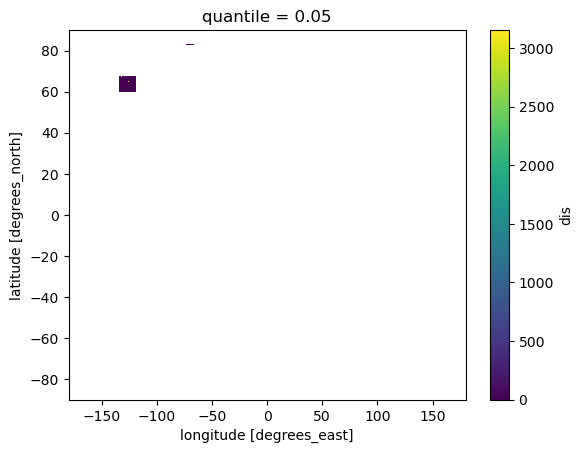

In [15]:
disenv.plot();

***

In [1]:
import pandas as pd
from pathlib import Path

In [2]:
path = Path('Z:/nahaUsers/casadje/GloFASv5/reservoirs')

In [5]:
pd.read_csv(path / 'tables' / 'glofas5_reservoirs.xlsx', encoding='latin-1')

ParserError: Error tokenizing data. C error: Expected 2 fields in line 5, saw 3
